In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('user_ad.csv')
data = data.iloc[:,1:]
data.head()

,userid,性别,年龄层级,消费层级,购物层级,是否大学生,城市级别,time_stamp,ad_id,nonclk,clk,cate_id,campaign_id,customer,brand,price,price_range,price_labels
0,421833,2,3,2.0,3,0,4.0,1646208713,164434,1,0,6143,123031,172647,128474.0,1980.0,"(1600.0, 3200.0]",4
1,421833,2,3,2.0,3,0,4.0,1646461817,164434,1,0,6143,123031,172647,128474.0,1980.0,"(1600.0, 3200.0]",4
2,113020,2,4,NaN,3,0,2.0,1646202617,164434,1,0,6143,123031,172647,128474.0,1980.0,"(1600.0, 3200.0]",4
3,61260,2,2,NaN,3,0,2.0,1646291263,164434,1,0,6143,123031,172647,128474.0,1980.0,"(1600.0, 3200.0]",4
4,61260,2,2,NaN,3,0,2.0,1646560274,164434,1,0,6143,123031,172647,128474.0,1980.0,"(1600.0, 3200.0]",4


In [3]:
data['消费层级'].value_counts() # 众数

2.0    167179
1.0     69626
3.0     32122
Name: 消费层级, dtype: int64

In [4]:
df1 = data.groupby(by=['userid'], as_index=False)[['消费层级','购物层级','price']].mean()
df2 = data.groupby(by=['userid'], as_index=False)[['nonclk','clk']].sum()
df2['total'] = df2['nonclk']+df2['clk']
df2['clk_ratio'] = df2['clk']/df2['total']
df = pd.merge(df1, df2, on='userid')

df.drop(['nonclk','clk','total'], axis=1, inplace=True)

from sklearn.impute import SimpleImputer
# 消费层级为空用众数补全
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=2)
df[['消费层级']] = imputer.fit_transform(df[['消费层级']])
df.head()

,userid,消费层级,购物层级,price,clk_ratio
0,1,2.0,3.0,2560.000000,0.00
1,3,2.0,2.0,128.000000,0.00
2,4,2.0,2.0,250.250000,0.25
3,7,1.0,3.0,354.949545,0.00
4,13,1.0,2.0,116.900000,0.00


## Kmeans聚类

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

df_X = df.drop(['userid'], axis=1)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_X.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=['消费层级','购物层级','price','clk_ratio'])
df_scaled.head()

,消费层级,购物层级,price,clk_ratio
0,0.5,1.0,2.459002e-05,0.00
1,0.5,0.5,2.700003e-07,0.00
2,0.5,0.5,1.492502e-06,0.25
3,0.0,1.0,2.539498e-06,0.00
4,0.0,0.5,1.590002e-07,0.00


In [6]:
kmeans = KMeans(n_clusters = 5, max_iter = 10000, random_state = 42)
kmeans.fit(df_scaled)
y_kmeans = kmeans.labels_+1 # cluster 1 to 5
df['cluster'] = y_kmeans
clustered = df[['userid','cluster']]
clustered.head()

,userid,cluster
0,1,1
1,3,2
2,4,2
3,7,3
4,13,3


## 根据RFM模型区分用户

In [7]:
centroids = round(pd.DataFrame(kmeans.cluster_centers_, columns=['消费层级','购物层级','price(M)','clk_ratio(F)']),8)
centroids['price(M)'] = centroids['price(M)']*1000
centroids['平均层级(R)'] = (centroids['消费层级']+centroids['购物层级'])/2
centroids['cluster'] = [1,2,3,4,5]
centroids['R'] = 0
centroids['F'] = 0
centroids['M'] = 0
for i in range(5):
    if centroids['price(M)'][i] > np.mean(centroids['price(M)']):
        centroids['M'][i] = '+'
    else: centroids['M'][i] = '-'
    if centroids['clk_ratio(F)'][i] > np.mean(centroids['clk_ratio(F)']):
        centroids['F'][i] = '+'
    else: centroids['F'][i] = '-'
    if centroids['平均层级(R)'][i] > np.mean(centroids['平均层级(R)']):
        centroids['R'][i] = '+'
    else: centroids['R'][i] = '-'
centroids

C:\Users\hejin\AppData\Local\Temp\ipykernel_20384\2433567775.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: centroids['M'][i] = '-'
C:\Users\hejin\AppData\Local\Temp\ipykernel_20384\2433567775.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: centroids['F'][i] = '-'
C:\Users\hejin\AppData\Local\Temp\ipykernel_20384\2433567775.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroids['R'][i] = '+'


,消费层级,购物层级,price(M),clk_ratio(F),平均层级(R),cluster,R,F,M
0,0.500000,1.000000,0.01207,0.019349,0.750000,1,+,-,-
1,0.492131,0.324754,0.03594,0.016556,0.408442,2,-,-,+
2,0.000000,0.944693,0.00970,0.017537,0.472346,3,-,-,-
3,1.000000,0.966171,0.10354,0.020354,0.983086,4,+,-,+
4,0.460982,0.866301,0.01133,0.989574,0.663641,5,+,+,-


In [8]:
centroids['用户群体'] = ['一般发展客户','重要挽留客户','一般挽留客户','重要发展客户','一般价值客户']
centroids

,消费层级,购物层级,price(M),clk_ratio(F),平均层级(R),cluster,R,F,M,用户群体
0,0.500000,1.000000,0.01207,0.019349,0.750000,1,+,-,-,一般发展客户
1,0.492131,0.324754,0.03594,0.016556,0.408442,2,-,-,+,重要挽留客户
2,0.000000,0.944693,0.00970,0.017537,0.472346,3,-,-,-,一般挽留客户
3,1.000000,0.966171,0.10354,0.020354,0.983086,4,+,-,+,重要发展客户
4,0.460982,0.866301,0.01133,0.989574,0.663641,5,+,+,-,一般价值客户


In [9]:
def user_type(value):
    if value == 1: return '一般发展客户'
    elif value == 2: return '重要挽留客户'
    elif value == 3: return '一般挽留客户'
    elif value == 4: return '重要发展客户'
    else: return '一般价值客户'

clustered['用户群体'] = clustered['cluster'].map(user_type)
clustered.head()

C:\Users\hejin\AppData\Local\Temp\ipykernel_20384\574478916.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered['用户群体'] = clustered['cluster'].map(user_type)


,userid,cluster,用户群体
0,1,1,一般发展客户
1,3,2,重要挽留客户
2,4,2,重要挽留客户
3,7,3,一般挽留客户
4,13,3,一般挽留客户


## 各用户群体占比

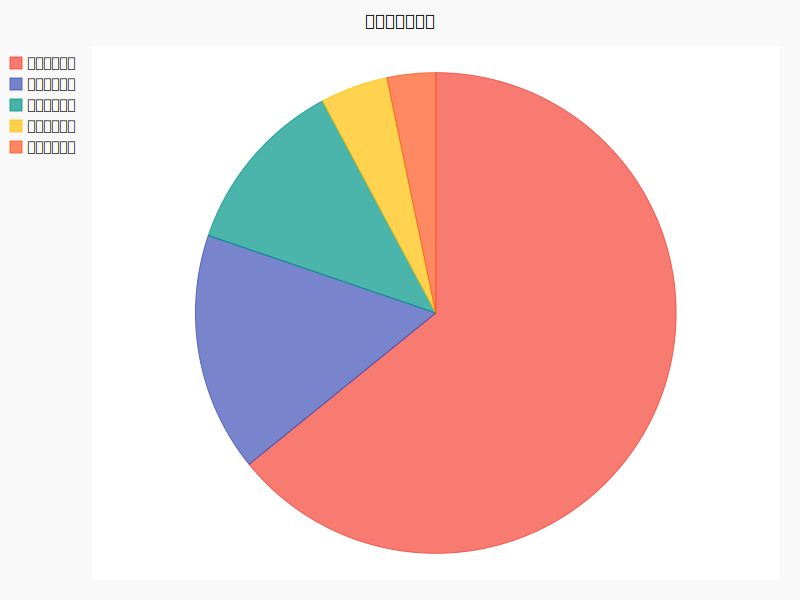

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pygal
from IPython.display import SVG, display
mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False

df_user = clustered.groupby(by=['cluster','用户群体'], as_index=False)['userid'].count()
pie_chart = pygal.Pie()
pie_chart.title = '各用户群体占比'
for i in range(5):
    pie_chart.add(df_user['用户群体'][i], df_user['userid'][i])
display(SVG(pie_chart.render(disable_xml_declaration=True)))
pie_chart.render_to_file('各用户群体占比.svg')

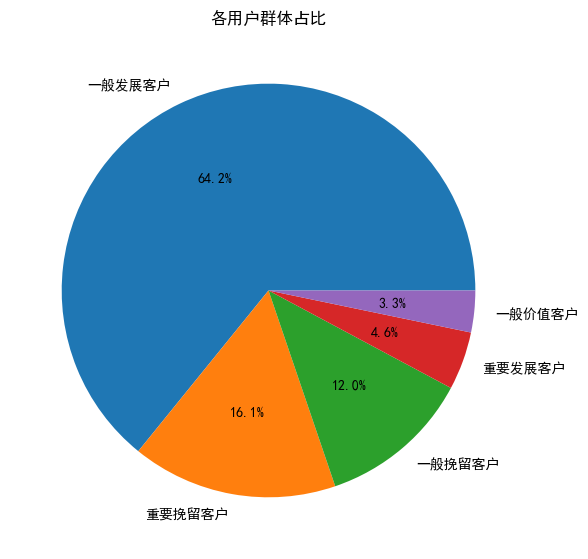

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(df_user['userid'], labels=df_user['用户群体'], autopct='%.1f%%')
ax.set_title('各用户群体占比')
plt.tight_layout()

## 各用户群体年龄占比

In [12]:
df_age = data[['userid','年龄层级']]
df_age = df_age.groupby(by=['userid'], as_index=False)['年龄层级'].mean()
df_age = df_age.merge(clustered, on='userid')
df1 = pd.get_dummies(df_age['年龄层级'], prefix='年龄层级')
df_age = pd.concat([df_age,df1],axis=1)
df_age = df_age.groupby(by=['cluster','用户群体'], as_index=False)[['年龄层级_0.0','年龄层级_1.0','年龄层级_2.0','年龄层级_3.0',\
                                                               '年龄层级_4.0','年龄层级_5.0','年龄层级_6.0']].sum()
df_age.columns = ['cluster','用户群体','年龄层级_0','年龄层级_1','年龄层级_2','年龄层级_3','年龄层级_4','年龄层级_5','年龄层级_6']
df_age

,cluster,用户群体,年龄层级_0,年龄层级_1,年龄层级_2,年龄层级_3,年龄层级_4,年龄层级_5,年龄层级_6
0,1,一般发展客户,48.0,4713.0,22284.0,50250.0,46960.0,35350.0,3539.0
1,2,重要挽留客户,28.0,3100.0,4608.0,9551.0,10379.0,11581.0,1607.0
2,3,一般挽留客户,17.0,2065.0,7986.0,8728.0,6243.0,4916.0,457.0
3,4,重要发展客户,2.0,84.0,578.0,3126.0,3917.0,3476.0,390.0
4,5,一般价值客户,6.0,385.0,1210.0,2316.0,2242.0,1896.0,236.0


Text(0.5, 0.98, '各用户群体年龄占比')

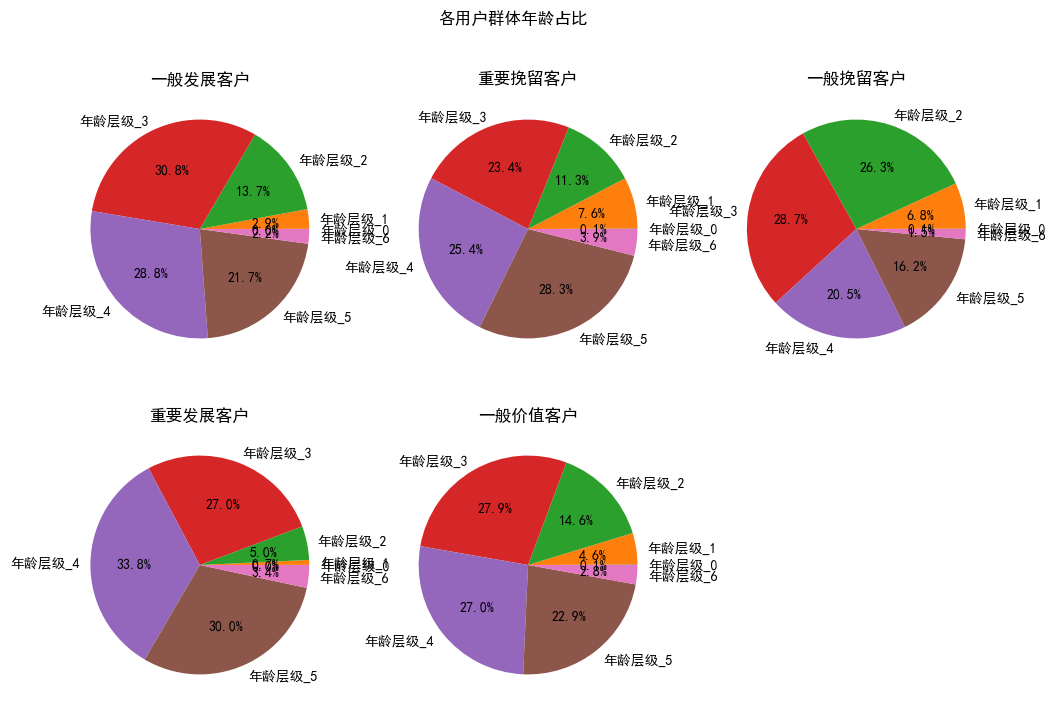

In [16]:
label = df_age.columns[2:]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[1][0]
ax5 = axes[1][1]
ax6 = axes[1][2]
ax6.axis('off')

ax1.pie(list(df_age.iloc[0][2:]), labels=label, autopct='%.1f%%')
ax1.set_title('一般发展客户')
ax2.pie(list(df_age.iloc[1][2:]), labels=label, autopct='%.1f%%')
ax2.set_title('重要挽留客户')
ax3.pie(list(df_age.iloc[2][2:]), labels=label, autopct='%.1f%%')
ax3.set_title('一般挽留客户')
ax4.pie(list(df_age.iloc[3][2:]), labels=label, autopct='%.1f%%')
ax4.set_title('重要发展客户')
ax5.pie(list(df_age.iloc[4][2:]), labels=label, autopct='%.1f%%')
ax5.set_title('一般价值客户')
fig.suptitle('各用户群体年龄占比')

## 各用户群体性别占比

In [17]:
df_sex = data[['userid','性别']]
df_sex = df_sex.groupby(by=['userid'], as_index=False)['性别'].mean()
df_sex = df_sex.merge(clustered, on='userid')
df2 = pd.get_dummies(df_sex['性别'], prefix='性别')
df_sex = pd.concat([df_sex,df2],axis=1)
df_sex = df_sex.groupby(by=['cluster','用户群体'], as_index=False)[['性别_1.0','性别_2.0']].sum()
df_sex.columns = ['cluster','用户群体','性别_1','性别_2']
df_sex['total'] = df_sex['性别_1']+df_sex['性别_2']
df_sex['性别_1_ratio'] = df_sex['性别_1']/df_sex['total']
df_sex['性别_2_ratio'] = df_sex['性别_2']/df_sex['total']
df_sex

,cluster,用户群体,性别_1,性别_2,total,性别_1_ratio,性别_2_ratio
0,1,一般发展客户,59834.0,103310.0,163144.0,0.366756,0.633244
1,2,重要挽留客户,21524.0,19330.0,40854.0,0.526852,0.473148
2,3,一般挽留客户,10417.0,19995.0,30412.0,0.342529,0.657471
3,4,重要发展客户,5655.0,5918.0,11573.0,0.488637,0.511363
4,5,一般价值客户,3298.0,4993.0,8291.0,0.397781,0.602219


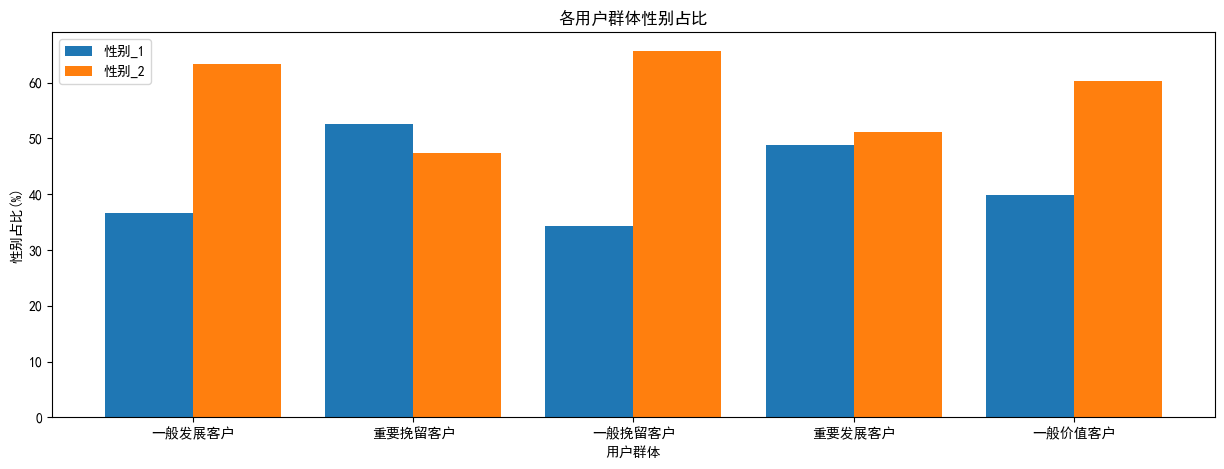

In [18]:
plt.figure(figsize=(15,5))
x_axis = np.arange(len(df_sex['用户群体']))
plt.bar(x_axis-0.2, df_sex['性别_1_ratio']*100, width=0.4, label='性别_1')
plt.bar(x_axis+0.2, df_sex['性别_2_ratio']*100, width=0.4, label='性别_2')
plt.xticks(x_axis,df_sex['用户群体'])
plt.legend(loc='upper left')
plt.xlabel('用户群体')
plt.ylabel('性别占比(%)')
plt.title('各用户群体性别占比')
plt.show()